# Gate Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [2]:
# File paths
binary_dir = "Verilog/binary/programs"
ternary_dir = "Verilog/ternary/programs"

In [6]:
# Read in all the binary and ternary csv files while getting the file names

def read_csv_files(directory):

    csv_files = glob.glob(os.path.join(directory, "*_results.csv"))

    # create an empty dataframe to concatenate all the dataframes
    df = pd.DataFrame()

    # Loop through each matching file
    for file_path in csv_files:
        file_name = os.path.basename(file_path) 
        name_part = file_name.split("_results.csv")[0]
        
        # Read the CSV file
        temp_df = pd.read_csv(file_path)

        # Pivot the dataframe to have the 'Gate' column as headers and 'Counts' as values
        temp_df = pd.DataFrame([temp_df.set_index('Gate')['Count'].to_dict()])
        
        # Add a 'name' column with the extracted value
        temp_df['operation'] = name_part
        
        # Append to our list of dataframes
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

binary_df = read_csv_files(binary_dir)
ternary_df = read_csv_files(ternary_dir)

# Add a column to indicate the type of data (binary or ternary)
binary_df['type'] = 'binary'
ternary_df['type'] = 'ternary'

# Combine the two dataframes
gc_df = pd.concat([binary_df, ternary_df], ignore_index=True)

# Replace any NaN values with 0
gc_df = gc_df.fillna(0)

# Convert the 'operation' column to a string type
gc_df['operation'] = gc_df['operation'].astype(str)
# Convert the 'type' column to a string type
gc_df['type'] = gc_df['type'].astype(str)
gc_df['ANY'] = gc_df['ANY'].astype(int)
gc_df['CONSENSUS'] = gc_df['CONSENSUS'].astype(int)

# Reorder the columns to have 'operation' and 'type' first
gc_df = gc_df[['type', 'operation'] + [col for col in gc_df.columns if col not in ['operation', 'type']]]

# Rename the CONSENSUS column to 'CON' for clarity
gc_df = gc_df.rename(columns={'CONSENSUS': 'CON'})

print(gc_df)

       type       operation  NOT  AND   OR  XOR  ANY  CON
0    binary             add    0   32   16   32    0    0
1    binary             and    0   16    0    0    0    0
2    binary        equality   16   16    0   16    0    0
3    binary       less_than   32   32   16   16    0    0
4    binary  multiplication  112  560  224  560    0    0
5    binary             not   16    0    0    0    0    0
6    binary              or    0    0   16    0    0    0
7    binary             sub   16   32   16   32    0    0
8    binary             xor    0    0    0   16    0    0
9   ternary             add   18    0    0    0   63   36
10  ternary             and    0    9    0    0    0    0
11  ternary        equality    9   27   18    9    0    0
12  ternary       less_than    9   27   18    9    0    0
13  ternary  multiplication  315  189  126   63  882  504
14  ternary             not    9    0    0    0    0    0
15  ternary              or    0    0    9    0    0    0
16  ternary   

In [12]:
# Set up the figure and axes with a clean, academic style
plt.rcParams.update({
    'font.family': 'serif',  # Serif fonts are standard in academic papers
    'font.size': 10,         # Base font size
    'axes.labelsize': 11,    # Slightly larger axis labels
    'axes.titlesize': 12,    # Slightly larger title
    'xtick.labelsize': 10,   # Tick label size
    'ytick.labelsize': 10,   # Tick label size
    'legend.fontsize': 10,   # Legend font size
    'figure.dpi': 300        # High resolution for print
})

# Get all gate types and operations
gates = ['NOT', 'AND', 'OR', 'XOR', 'ANY', 'CON']
ops = gc_df['operation'].unique()

def plot_gate_usage(gc_df, gate_types, operations, figure_name=None, n_cols=3):
    # We'll create a grid with each operation as a separate subplot
    n_operations = len(operations)
    n_rows = (n_operations + n_cols - 1) // n_cols  # Calculate needed rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), squeeze=False)

    # Define colors for binary and ternary
    binary_color = '#777777'  # Grey
    ternary_color = '#4477AA'  # Blue

    # Add patterns for grayscale printing
    binary_hatch = ''
    ternary_hatch = '//'

    # Process each operation
    for i, operation in enumerate(operations):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]
        
        operation_data = gc_df[gc_df['operation'] == operation]
        
        # Get binary and ternary data for this operation
        binary_data = operation_data[operation_data['type'] == 'binary']
        ternary_data = operation_data[operation_data['type'] == 'ternary']
        
        # Set up bar positions
        x = np.arange(len(gate_types))
        width = 0.35
        
        # Plot binary data (left bars)
        binary_values = [0] * len(gate_types)
        if not binary_data.empty:
            binary_values = binary_data[gate_types].iloc[0].tolist()
        
        binary_bars = ax.bar(x - width/2, binary_values, width, label='Binary', 
                            color=binary_color, edgecolor='black', linewidth=0.5, hatch=binary_hatch)
        
        # Plot ternary data (right bars)
        ternary_values = [0] * len(gate_types)
        if not ternary_data.empty:
            ternary_values = ternary_data[gate_types].iloc[0].tolist()
        
        ternary_bars = ax.bar(x + width/2, ternary_values, width, label='Ternary', 
                            color=ternary_color, edgecolor='black', linewidth=0.5, hatch=ternary_hatch)
        
        # Add value labels on bars
        for j, v in enumerate(binary_values):
            if v > 0:  # Only label non-zero values
                ax.text(j - width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)
        
        for j, v in enumerate(ternary_values):
            if v > 0:  # Only label non-zero values
                ax.text(j + width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)
        
        # Set y scale to log if we have very large values compared to small ones
        all_values = binary_values + ternary_values
        non_zero_values = [v for v in all_values if v > 0]
        
        if non_zero_values:
            max_val = max(non_zero_values)
            min_val = min(non_zero_values)
            
            if max_val / min_val > 50:  # If largest value is >50x the smallest non-zero value
                # Use log scale
                ax.set_yscale('log')
        
        # Configure axes
        ax.set_title(f'{operation.capitalize()}', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(gate_types, rotation=45, ha='right')
        
        # Add gridlines
        ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
        ax.set_axisbelow(True)  # Place gridlines behind data
        
        # Customize spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend only for the first subplot
        if i == 0:
            ax.legend(frameon=True, framealpha=1, edgecolor='black', fancybox=False)

    # Hide empty subplots if any
    for i in range(n_operations, n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        axes[row_idx, col_idx].set_visible(False)

    # Add main title
    # plt.suptitle('Gate Usage by Operation: Binary vs Ternary', fontweight='bold', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout with space for the title
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add space between subplots

    # Add a subtle border around the figure
    fig.patch.set_linewidth(1)
    fig.patch.set_edgecolor('black')

    # Uncomment to save
    if figure_name:
        plt.savefig(f'Diss/figures/{figure_name}.png', dpi=300, bbox_inches='tight')  # PNG for preview
        plt.close()  # Close the figure to free up memory
    else:
        plt.show()

In [13]:
basic_operations = ['not', 'and', 'or', 'xor']
complex_operations = list(set(ops) - set(basic_operations))

plot_gate_usage(gc_df, gates, basic_operations, n_cols=2, figure_name='trivial_gate_usage')
plot_gate_usage(gc_df, gates, complex_operations, n_cols=2, figure_name='complex_gate_usage')

In [6]:
# 2. Pie charts
binary_total = sum(binary_counts.values())
ternary_total = sum(ternary_counts.values())

binary_labels = [f"{gate}\n({count}, {count/binary_total:.1%})" for gate, count in binary_counts.items()]
ternary_labels = [f"{gate}\n({count}, {count/ternary_total:.1%})" for gate, count in ternary_counts.items()]

ax2.pie(binary_counts.values(), labels=binary_labels, autopct='', startangle=90, 
        wedgeprops={'alpha': 0.6}, radius=1)
ax2.pie(ternary_counts.values(), labels=ternary_labels, autopct='', startangle=90, 
        wedgeprops={'alpha': 0.6}, radius=0.7)

centre_circle = plt.Circle((0, 0), 0.4, fc='white')
ax2.add_patch(centre_circle)

ax2.set_title('Gate Distribution (Outer: Binary, Inner: Ternary)')

# Add a title for the whole figure
plt.suptitle('Binary vs Ternary Logic: Gate Usage Analysis', fontsize=16)

plt.tight_layout()
plt.show()

NameError: name 'ax2' is not defined

In [7]:
# 3. Ratio comparison (separate visualization)
plt.figure(figsize=(10, 6))

ratios = []
for gate in all_gates:
    binary_val = binary_counts.get(gate, 0)
    ternary_val = ternary_counts.get(gate, 0)
    
    # Avoid division by zero
    if binary_val > 0 and ternary_val > 0:
        ratio = ternary_val / binary_val
        ratios.append((gate, ratio))

if ratios:
    ratios.sort(key=lambda x: x[1], reverse=True)
    gates_with_ratios, ratio_values = zip(*ratios)
    
    plt.bar(gates_with_ratios, ratio_values, color='purple')
    plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
    
    plt.title('Ternary/Binary Gate Usage Ratio')
    plt.ylabel('Ratio (Ternary ÷ Binary)')
    plt.xticks(rotation=45)
    
    # Add ratio values on top of each bar
    for i, v in enumerate(ratio_values):
        plt.text(i, v + 0.05, f"{v:.2f}x", ha='center')
    
    plt.tight_layout()
    plt.show()

<Figure size 3000x1800 with 0 Axes>

## CNFET vs. CMOS Propagation Delay

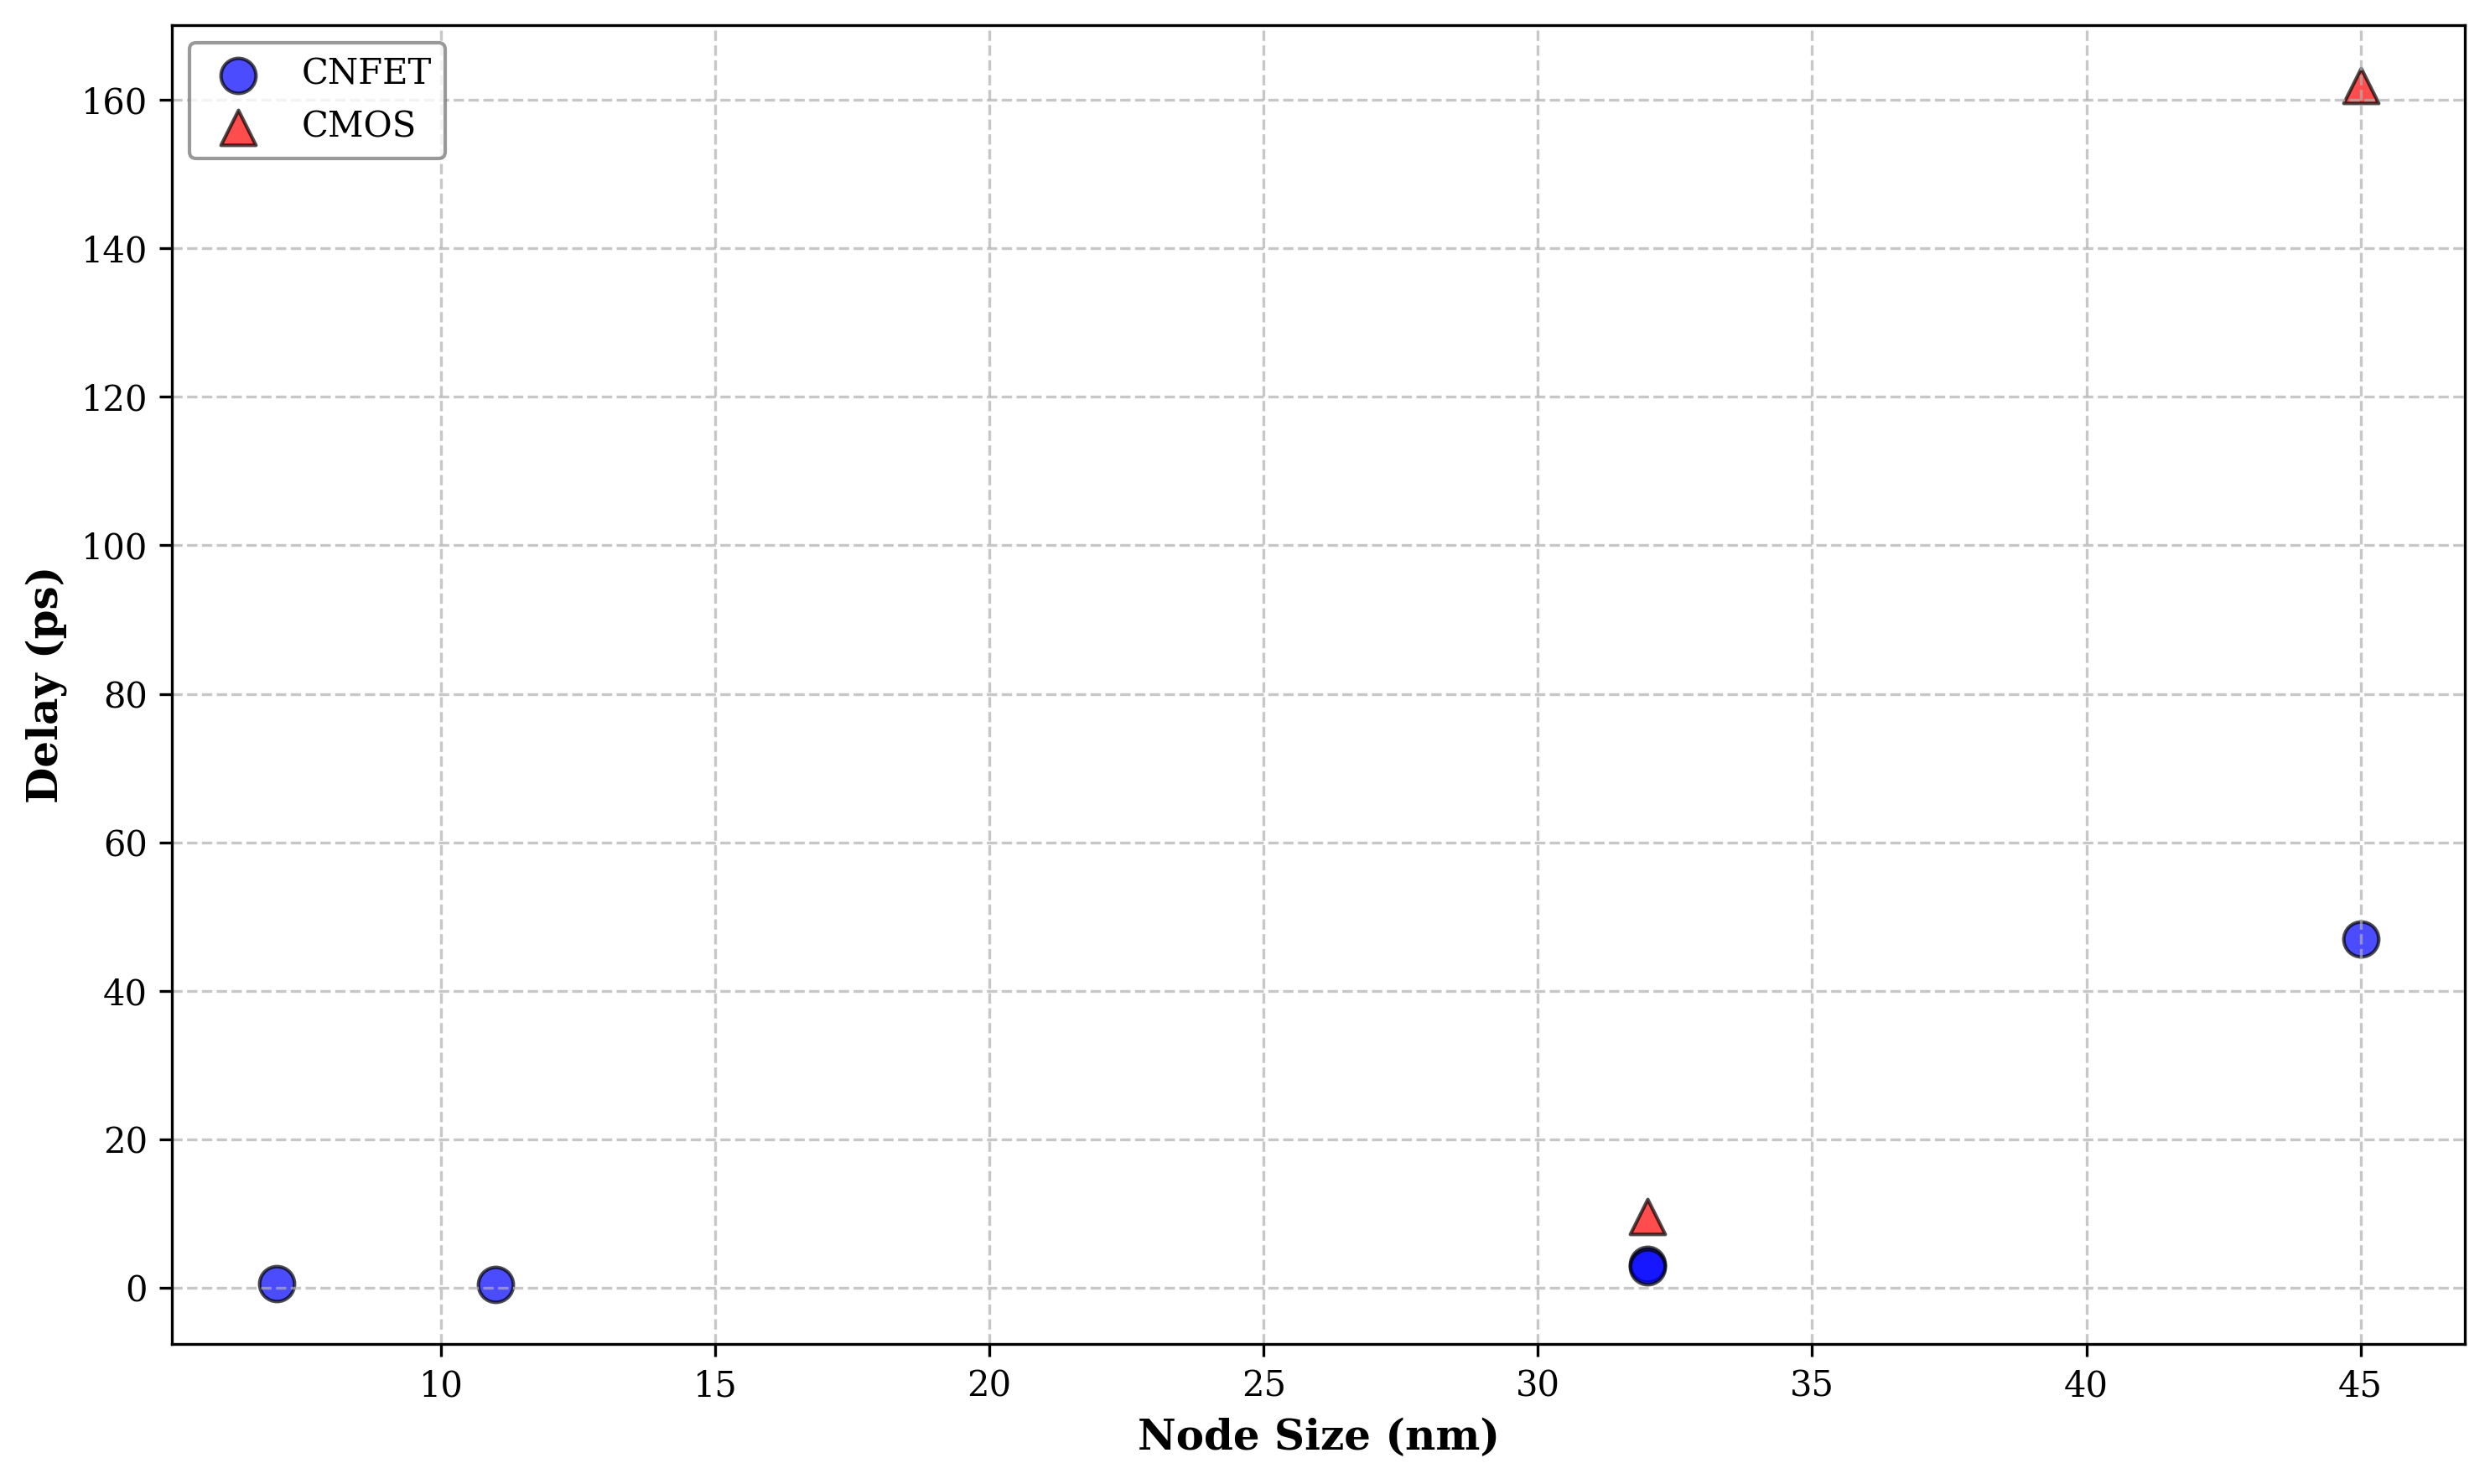

In [8]:
# Data from the table
gates = ['CNFET', 'CNFET', 'CNFET', 'CMOS', 'CNFET', 'CNFET', 'CMOS']
node_sizes = [11, 7, 45, 45, 32, 32, 32]
delays = [0.48, 0.55, 47, 162, 3.11, 2.79, 9.55]

# gates = ['CNFET', 'CNFET', 'CNFET', 'CNFET', 'CMOS']
# node_sizes = [11, 7, 32, 32, 32]
# delays = [0.48, 0.55, 3.11, 2.79, 9.55]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Separate CNFET and CMOS data
cnfet_sizes = [size for size, gate in zip(node_sizes, gates) if gate == 'CNFET']
cnfet_delays = [delay for delay, gate in zip(delays, gates) if gate == 'CNFET']
cmos_sizes = [size for size, gate in zip(node_sizes, gates) if gate == 'CMOS']
cmos_delays = [delay for delay, gate in zip(delays, gates) if gate == 'CMOS']

# Plot CNFET data
plt.scatter(cnfet_sizes, cnfet_delays, color='blue', marker='o', label='CNFET', 
            edgecolors='black', linewidth=1, alpha=0.7, s=100)

# Plot CMOS data
plt.scatter(cmos_sizes, cmos_delays, color='red', marker='^', label='CMOS', 
            edgecolors='black', linewidth=1, alpha=0.7, s=100)

# Customize the plot
plt.xlabel('Node Size (nm)', fontsize=12, fontweight='bold')
plt.ylabel('Delay (ps)', fontsize=12, fontweight='bold')
# plt.title('Comparison of CNFET and CMOS - Node Size vs Delay', 
        #   fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, framealpha=0.8, edgecolor='gray')

# Add a tight layout and show the plot
plt.tight_layout()
plt.savefig('Diss/figures/cnfet_cmos_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## LUI Instruction Visualisation

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

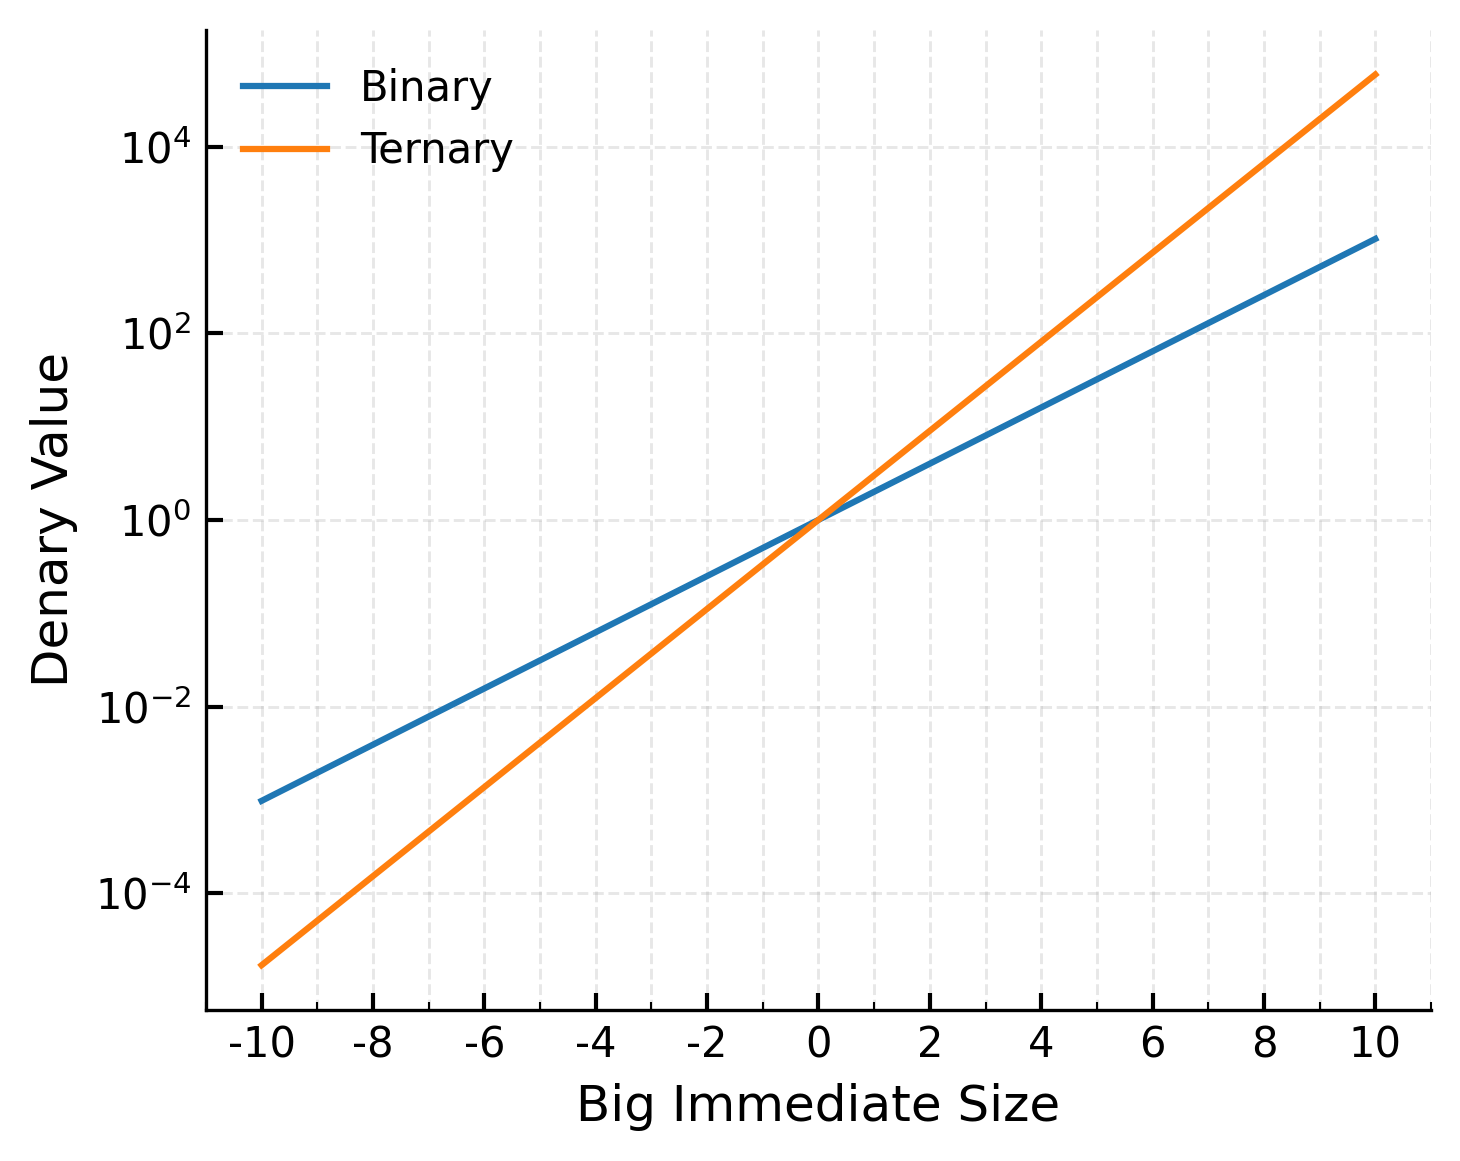

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.ticker as ticker

# Set up the matplotlib parameters for academic style WITHOUT LaTeX
plt.rcParams.update({
    'font.size': 11,
    'text.usetex': False,  # Disable LaTeX rendering
    'mathtext.default': 'regular',  # Still use math formatting
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (5, 4),
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.axisbelow': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Create x values
x = np.linspace(-10, 10, 1000)

# Calculate y values
y1 = 2**x
y2 = 3**x

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the functions
ax.semilogy(x, y1, label='Binary', color='#1f77b4')
ax.semilogy(x, y2, label='Ternary', color='#ff7f0e')

# Adjust grid
ax.grid(True, which="both", linestyle='--', linewidth=0.7)

# Set integer ticks on x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Major ticks every 2 units
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))  # Minor ticks every 1 unit
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))  # Format as integers

# Add labels and title
ax.set_xlabel('Big Immediate Size')
ax.set_ylabel('Denary Value')

# Adjust tick marks
ax.tick_params(direction='in', length=4, width=1)
ax.tick_params(which='minor', direction='in', length=2, width=0.5)

# Add legend
ax.legend(frameon=False)

# Adjust layout
plt.tight_layout()

plt.savefig('Diss/figures/exponential_functions.png', bbox_inches='tight', dpi=300)
plt.show()